<a href="https://colab.research.google.com/github/shrushenoy/Predicting-No-Show-Rate-for-Hospital-Appointments/blob/master/Patients%20No-Show%20Prediction%20Model..ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import time
import datetime as dt
sns.set_style("whitegrid")
from scipy.stats import chi2_contingency
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
ls

sample_data/


In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [4]:
cd /content/gdrive/My Drive/Courses/Spring 2020/ML/project/

/content/gdrive/My Drive/Courses/Spring 2020/ML/project


In [5]:
df = pd.read_csv('noshow.csv')
df.head()

,Age,Gender,AppointmentRegistration,ApointmentData,Day,Status,Diabetes,Alcoolism,HiperTension,Handcap,Scholarship,Sms_Reminder
0,19,M,2014-12-16T14:46:25Z,2015-01-14T00:00:00Z,Tuesday,noshow,0,0,0,0,0,0
1,24,F,2015-08-18T07:01:26Z,2015-08-19T00:00:00Z,Tuesday,noshow,0,0,0,0,0,0
2,4,F,2014-02-17T12:53:46Z,2014-02-18T00:00:00Z,Monday,noshow,0,0,0,0,0,0
3,5,M,2014-07-23T17:02:11Z,2014-08-07T00:00:00Z,Wednesday,noshow,0,0,0,0,0,0
4,38,M,2015-10-21T15:20:09Z,2015-10-27T00:00:00Z,Wednesday,noshow,0,0,0,0,0,0


In [6]:
df.shape[0]

410526

In [7]:

#renaming column to make it easier 
new_col_name = ['age', 'gender','schedule_day','appointment_day','week_day', 'no_show',
                'diabetes','alcoholism','hypertension','handicap', 'scholarship',
                'sms_received']
df.columns = new_col_name
df.head()

,age,gender,schedule_day,appointment_day,week_day,no_show,diabetes,alcoholism,hypertension,handicap,scholarship,sms_received
0,19,M,2014-12-16T14:46:25Z,2015-01-14T00:00:00Z,Tuesday,noshow,0,0,0,0,0,0
1,24,F,2015-08-18T07:01:26Z,2015-08-19T00:00:00Z,Tuesday,noshow,0,0,0,0,0,0
2,4,F,2014-02-17T12:53:46Z,2014-02-18T00:00:00Z,Monday,noshow,0,0,0,0,0,0
3,5,M,2014-07-23T17:02:11Z,2014-08-07T00:00:00Z,Wednesday,noshow,0,0,0,0,0,0
4,38,M,2015-10-21T15:20:09Z,2015-10-27T00:00:00Z,Wednesday,noshow,0,0,0,0,0,0


In [8]:
#checking for null values
df.isnull().sum()

age                0
gender             0
schedule_day       0
appointment_day    0
week_day           0
no_show            0
diabetes           0
alcoholism         0
hypertension       0
handicap           0
scholarship        0
sms_received       0
dtype: int64

In [0]:
#sns.heatmap(df.isnull(), cmap='viridis')

In [10]:
#creating a function to find unique values for each feature 

def data(df, limit=5):  
    print(f"Dataset Shape: {df.shape}")
    print('Unique values in feature: ')
    print(df.nunique())
        
data(df)

Dataset Shape: (410526, 12)
Unique values in feature: 
age                   110
gender                  2
schedule_day       398972
appointment_day       561
week_day                6
no_show                 2
diabetes                2
alcoholism              2
hypertension            2
handicap                5
scholarship             2
sms_received            2
dtype: int64


In [11]:
#basic statistics 
df.describe()

,age,diabetes,alcoholism,hypertension,handicap,scholarship,sms_received
count,410526.000000,410526.000000,410526.000000,410526.000000,410526.000000,410526.000000,410526.000000
mean,37.614465,0.076324,0.026461,0.210871,0.020988,0.097268,0.478727
std,22.892679,0.265516,0.160502,0.407927,0.157466,0.296323,0.499548
min,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,115.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000


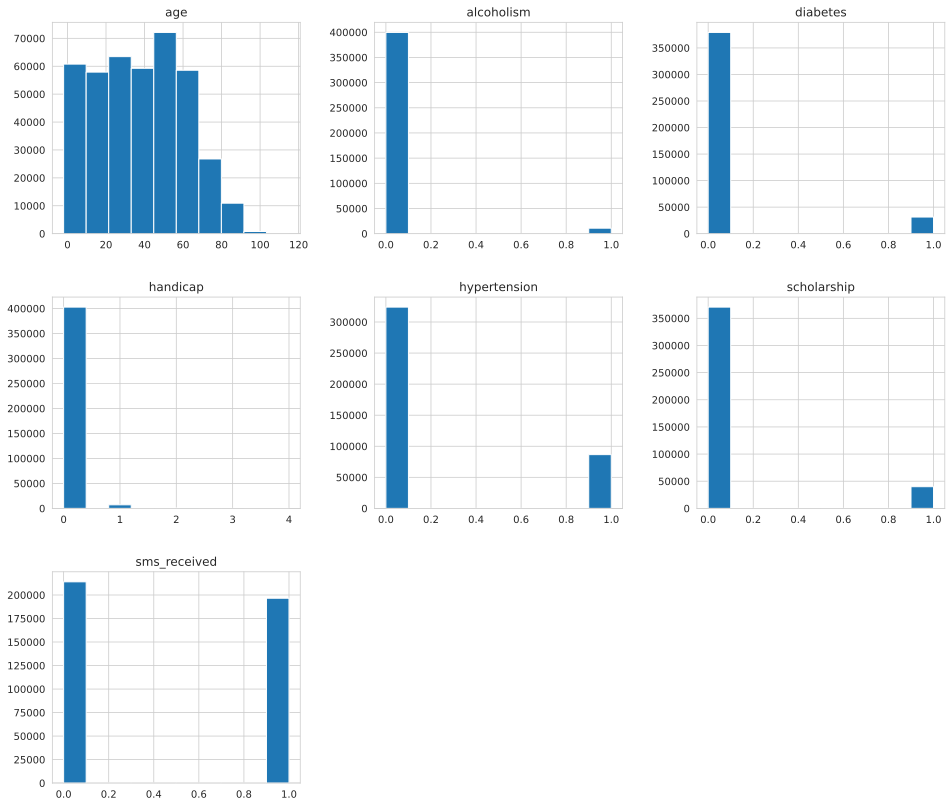

In [12]:
df.hist(figsize=(16,14));

noshow    231587
showup    178939
Name: no_show, dtype: int64


Text(0.5, 1.0, 'Show/No-show Patient')

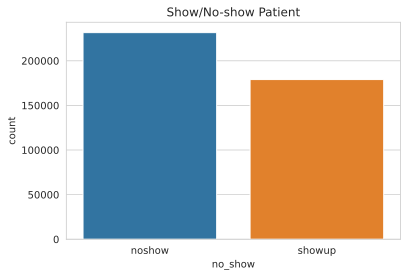

In [13]:
print(df['no_show'].value_counts())
sns.countplot(x='no_show', data=df).set_title('Show/No-show Patient')


In [0]:

#Creating a fucntion to calculate probability of feature with respect to no_show

#used later in code
def probStatus(dataset, group_by):
    df = pd.crosstab(index = dataset[group_by], columns = dataset.no_show).reset_index()
    df['probShowUp'] = df['showup'] / (df['showup'] + df['noshow'])
    return data[[group_by, 'probShowUp']]

In [15]:
#checking uniques age values
print ("Age range: ", sorted(df['age'].unique()))

Age range:  [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 108, 113, 115]


In [17]:
sns.stripplot(data = df, y = 'age', jitter = True)
plt.show()

KeyboardInterrupt: ignored

In [18]:
df[df['age'] > 105]

,age,gender,schedule_day,appointment_day,week_day,no_show,diabetes,alcoholism,hypertension,handicap,scholarship,sms_received
42450,113,F,2014-01-30T15:42:05Z,2014-02-04T00:00:00Z,Thursday,noshow,0,0,1,0,0,0
146771,113,F,2013-12-26T13:38:36Z,2014-01-09T00:00:00Z,Thursday,noshow,0,0,1,0,0,1
261053,113,F,2014-09-11T15:11:05Z,2014-09-12T00:00:00Z,Thursday,showup,0,0,0,1,0,0
261754,108,F,2014-08-19T13:37:44Z,2014-08-20T00:00:00Z,Tuesday,noshow,0,0,0,0,0,0
363911,115,F,2016-05-16T09:17:44Z,2016-05-19T00:00:00Z,Monday,noshow,0,0,0,1,0,0
363914,115,F,2016-05-16T09:17:44Z,2016-05-19T00:00:00Z,Monday,noshow,0,0,0,1,0,0
368126,115,F,2016-04-08T14:29:17Z,2016-05-16T00:00:00Z,Friday,noshow,0,0,0,1,0,0
376283,115,F,2016-05-30T09:44:51Z,2016-05-30T00:00:00Z,Monday,showup,0,0,0,1,0,0
397665,115,F,2016-05-19T07:57:56Z,2016-06-03T00:00:00Z,Thursday,showup,0,0,1,0,0,1


In [19]:
# dropping -ve age and row above 105 years
df = df[(df.age >= 0) & (df.age <= 105)]

min_age = df['age'].min()
max_age = df['age'].max()
print ("Age now spans values from: {} to {}.".format(min_age, max_age))

Age now spans values from: 0 to 104.


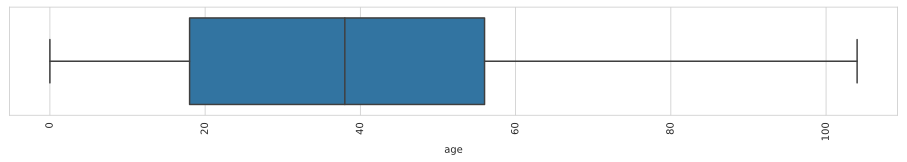

In [20]:
plt.figure(figsize=(16,2))
plt.xticks(rotation=90)
sns.boxplot(x=df.age)

In [21]:
#Creating bins for age groups 
age_ranges = [0, 12, 18, 25, 60, 75]
age_names = ["Children", "Teenager", 'Young-Adult', 'Adult', 'Senior']

df['age_bin'] = pd.cut(np.array(df['age']),bins=age_ranges, labels=age_names)
df.head()

,age,gender,schedule_day,appointment_day,week_day,no_show,diabetes,alcoholism,hypertension,handicap,scholarship,sms_received,age_bin
0,19,M,2014-12-16T14:46:25Z,2015-01-14T00:00:00Z,Tuesday,noshow,0,0,0,0,0,0,Young-Adult
1,24,F,2015-08-18T07:01:26Z,2015-08-19T00:00:00Z,Tuesday,noshow,0,0,0,0,0,0,Young-Adult
2,4,F,2014-02-17T12:53:46Z,2014-02-18T00:00:00Z,Monday,noshow,0,0,0,0,0,0,Children
3,5,M,2014-07-23T17:02:11Z,2014-08-07T00:00:00Z,Wednesday,noshow,0,0,0,0,0,0,Children
4,38,M,2015-10-21T15:20:09Z,2015-10-27T00:00:00Z,Wednesday,noshow,0,0,0,0,0,0,Adult


In [22]:
#checking unique age groups
df.age_bin.unique()

[Young-Adult, Children, Adult, Senior, Teenager, NaN]
Categories (5, object): [Children < Teenager < Young-Adult < Adult < Senior]

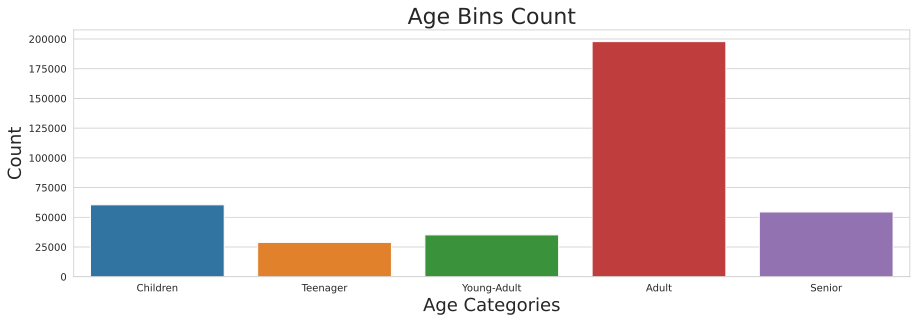

In [23]:
# now stack and reset
show_prob_age = pd.crosstab(df['age_bin'], df['no_show'], normalize='index')
plt.figure(figsize=(15,10))
plt.subplot(211)
ax1 = sns.countplot(x="age_bin", data=df)
ax1.set_title("Age Bins Count", fontsize=22)
ax1.set_xlabel("Age Categories", fontsize=18)
ax1.set_ylabel("Count", fontsize=18)

plt.show()

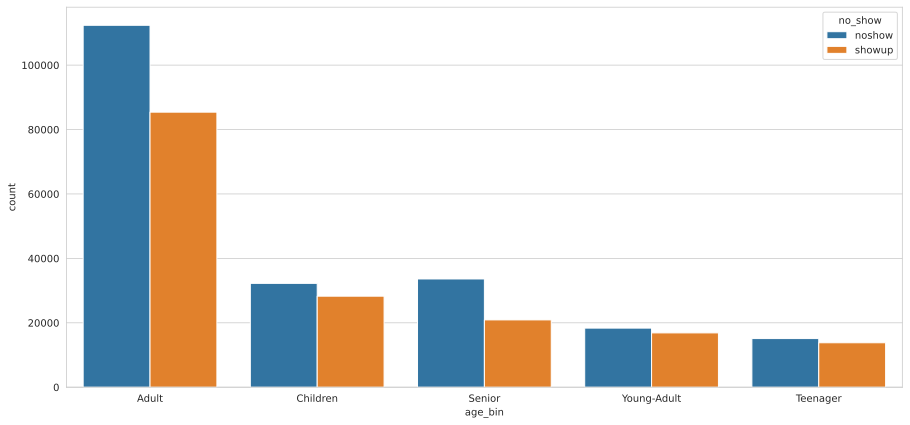

In [24]:
plt.figure(figsize = (15,7))
sns.countplot(x='age_bin', hue='no_show', data=df, order = df['age_bin'].value_counts().index)

In [25]:
sns.lmplot(data = probStatus(df, 'age'), x = 'age', y = 'probShowUp', 
           fit_reg = True, line_kws={'color': 'red'})
print('\bProbability of showing up with respect to Age')

TypeError: ignored

In [26]:

#Converting the schedule and appointment date from ISO8601 to standard format
df.schedule_day = df.schedule_day.apply(np.datetime64)
df.appointment_day = df.appointment_day.apply(np.datetime64)

print(df.schedule_day.head())
print(df.appointment_day.head())

0   2014-12-16 14:46:25
1   2015-08-18 07:01:26
2   2014-02-17 12:53:46
3   2014-07-23 17:02:11
4   2015-10-21 15:20:09
Name: schedule_day, dtype: datetime64[ns]
0   2015-01-14
1   2015-08-19
2   2014-02-18
3   2014-08-07
4   2015-10-27
Name: appointment_day, dtype: datetime64[ns]


In [27]:
#calculating waiting time 
appointment_waiting_time = df['appointment_day'] - df['schedule_day']
appointment_waiting_time = appointment_waiting_time.apply(lambda x: x.total_seconds() / (3600 * 24))

#adding column waiting_time into dataframe
df['waiting_time'] = appointment_waiting_time.round(1)
df.head(3)

,age,gender,schedule_day,appointment_day,week_day,no_show,diabetes,alcoholism,hypertension,handicap,scholarship,sms_received,age_bin,waiting_time
0,19,M,2014-12-16 14:46:25,2015-01-14,Tuesday,noshow,0,0,0,0,0,0,Young-Adult,28.4
1,24,F,2015-08-18 07:01:26,2015-08-19,Tuesday,noshow,0,0,0,0,0,0,Young-Adult,0.7
2,4,F,2014-02-17 12:53:46,2014-02-18,Monday,noshow,0,0,0,0,0,0,Children,0.5


In [28]:
sns.stripplot(data = df, y = 'waiting_time', jitter = True)
plt.show()

KeyboardInterrupt: ignored

In [29]:
#checking for number of rows for waiting time less than 0
df[df['waiting_time'] < 0]

,age,gender,schedule_day,appointment_day,week_day,no_show,diabetes,alcoholism,hypertension,handicap,scholarship,sms_received,age_bin,waiting_time
299999,62,F,2016-04-29 18:38:08,2016-04-29,Friday,showup,0,0,1,0,0,0,Senior,-0.8
300000,56,M,2016-04-29 16:08:27,2016-04-29,Friday,showup,0,0,0,0,0,0,Adult,-0.7
300001,62,F,2016-04-29 16:19:04,2016-04-29,Friday,showup,0,0,0,0,0,0,Senior,-0.7
300002,8,F,2016-04-29 17:29:31,2016-04-29,Friday,showup,0,0,0,0,0,0,Children,-0.7
300003,56,F,2016-04-29 16:07:23,2016-04-29,Friday,showup,1,0,1,0,0,0,Adult,-0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410510,14,F,2016-06-08 08:50:20,2016-06-08,Wednesday,showup,0,0,0,0,0,0,Teenager,-0.4
410511,41,F,2016-06-08 08:20:01,2016-06-08,Wednesday,showup,0,0,0,0,0,0,Adult,-0.3
410512,2,M,2016-06-08 07:52:55,2016-06-08,Wednesday,showup,0,0,0,0,0,0,Children,-0.3
410513,58,F,2016-06-08 08:35:31,2016-06-08,Wednesday,showup,0,0,0,0,0,0,Adult,-0.4


In [0]:
# removeing records below waiting time 0 and above 350
df = df[(df.waiting_time >= 0) & (df.waiting_time <= 350)]

In [31]:
print('Minimum waiting time is:', df['waiting_time'].min())
print('Maximum waiting time is:', df['waiting_time'].max())

Minimum waiting time is: 0.1
Maximum waiting time is: 349.6


In [32]:
print('Probability of showing up with respect to AwaitingTime')
sns.lmplot(data = probStatus(df, 'waiting_time'), x = 'waiting_time', 
           y = 'probShowUp', fit_reg = True, line_kws={'color': 'red'})

Probability of showing up with respect to AwaitingTime


TypeError: ignored

In [33]:
#Calculating appointment Month

df['appointment_month'] = df['appointment_day'].apply(lambda x : dt.datetime.strftime(x, '%B'))
df.head()

,age,gender,schedule_day,appointment_day,week_day,no_show,diabetes,alcoholism,hypertension,handicap,scholarship,sms_received,age_bin,waiting_time,appointment_month
0,19,M,2014-12-16 14:46:25,2015-01-14,Tuesday,noshow,0,0,0,0,0,0,Young-Adult,28.4,January
1,24,F,2015-08-18 07:01:26,2015-08-19,Tuesday,noshow,0,0,0,0,0,0,Young-Adult,0.7,August
2,4,F,2014-02-17 12:53:46,2014-02-18,Monday,noshow,0,0,0,0,0,0,Children,0.5,February
3,5,M,2014-07-23 17:02:11,2014-08-07,Wednesday,noshow,0,0,0,0,0,0,Children,14.3,August
4,38,M,2015-10-21 15:20:09,2015-10-27,Wednesday,noshow,0,0,0,0,0,0,Adult,5.4,October


In [34]:
#Checking unique values for appointment_month
df.appointment_month.unique()

array(['January', 'August', 'February', 'October', 'July', 'June',
       'November', 'May', 'March', 'April', 'September', 'December'],
      dtype=object)

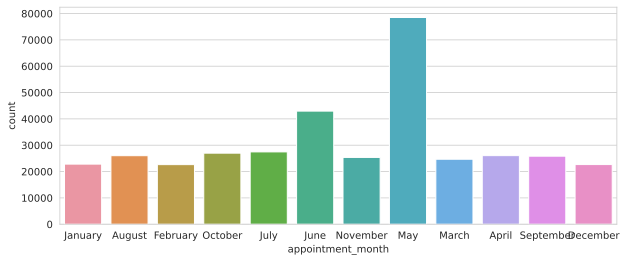

In [35]:
plt.figure(figsize = (10, 4))
sns.countplot(x='appointment_month', data = df)

In [36]:
#Creating a function to calculate hours of appointment
def calculate_hour(timestamp):
    timestamp = str(timestamp)
    hour = int(timestamp[11:13])
    minute = int(timestamp[14:16])
    second = int(timestamp[17:])
    return round(hour + minute/60 + second/3600)

df['hour_of_day'] = df.schedule_day.apply(calculate_hour)
df.head(5)

,age,gender,schedule_day,appointment_day,week_day,no_show,diabetes,alcoholism,hypertension,handicap,scholarship,sms_received,age_bin,waiting_time,appointment_month,hour_of_day
0,19,M,2014-12-16 14:46:25,2015-01-14,Tuesday,noshow,0,0,0,0,0,0,Young-Adult,28.4,January,15
1,24,F,2015-08-18 07:01:26,2015-08-19,Tuesday,noshow,0,0,0,0,0,0,Young-Adult,0.7,August,7
2,4,F,2014-02-17 12:53:46,2014-02-18,Monday,noshow,0,0,0,0,0,0,Children,0.5,February,13
3,5,M,2014-07-23 17:02:11,2014-08-07,Wednesday,noshow,0,0,0,0,0,0,Children,14.3,August,17
4,38,M,2015-10-21 15:20:09,2015-10-27,Wednesday,noshow,0,0,0,0,0,0,Adult,5.4,October,15


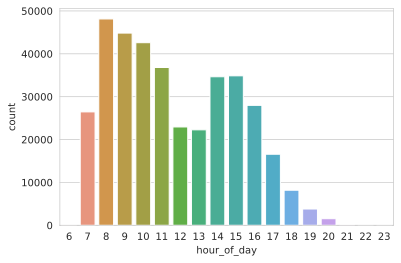

In [37]:

sns.countplot(x='hour_of_day', data=df)

In [38]:

#Checking relation between gender and no_show
gender_noshow = pd.crosstab(index=df["gender"],columns=df["no_show"])
gender_noshow

no_show,noshow,showup
gender,,
F,154277,94282
M,75503,47881


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

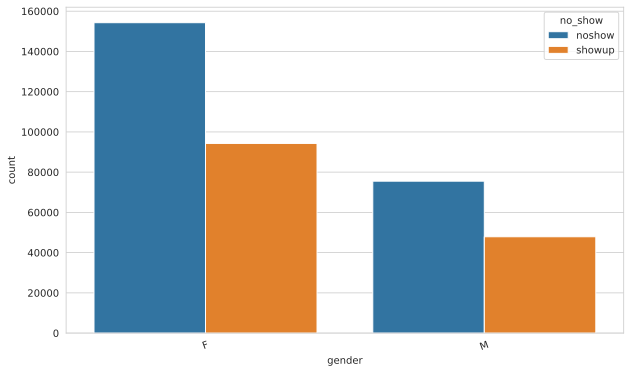

In [39]:
plt.figure(figsize = (10,6))
sns.countplot(x='gender', hue='no_show', data=df, order = df['gender'].value_counts().index)
plt.xticks(rotation=20)

In [0]:

cat_features = ['diabetes', 'alcoholism', 'hypertension', 'scholarship', 'handicap', 'sms_received' ]

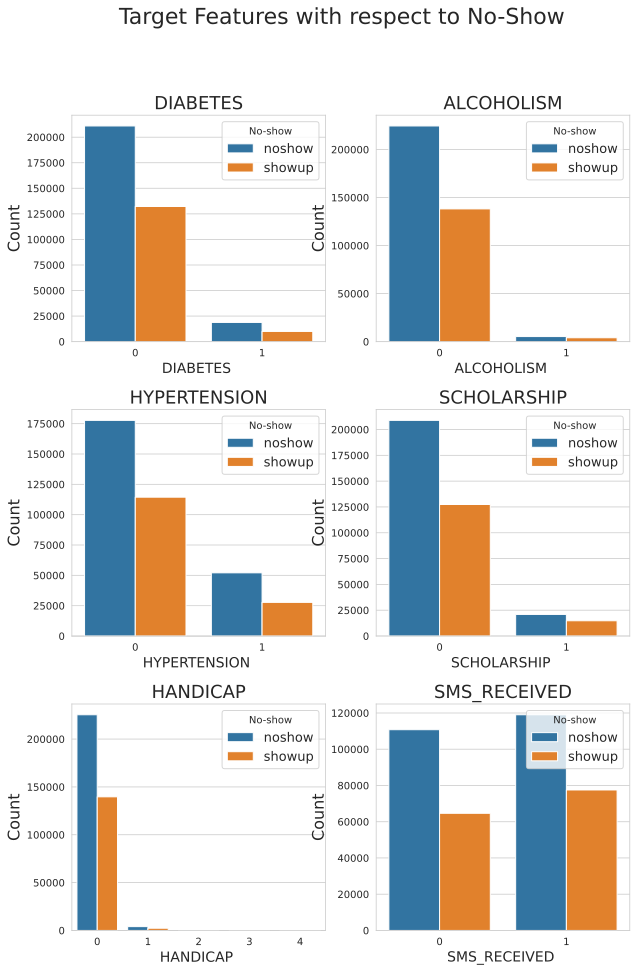

In [41]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,15))
fig.subplots_adjust(hspace=0.3)
fig.suptitle('Target Features with respect to No-Show', fontsize=22)

for ax, catplot in zip(axes.flatten(), df[cat_features].columns):
    sns.countplot(x=catplot, data=df, hue='no_show', ax=ax)
    ax.set_title(catplot.upper(), fontsize=18)
    ax.set_ylabel('Count', fontsize=16)
    ax.set_xlabel(f'{catplot.upper()} ', fontsize=14)
    ax.legend(title='No-show', fontsize=13 )

In [42]:
#To confirm the above result checking the pvalue

chi_test_var = ['diabetes', 'alcoholism', 'hypertension', 'scholarship', 'handicap', 'sms_received' ]
for column in (chi_test_var):
    chi2, p, dof,ex = chi2_contingency(pd.crosstab(index=df[column], columns=df["no_show"]), correction=False)
    print ('chi-squared test- p value for {} is: {r:6.5f}'. format(column,r = p))

chi-squared test- p value for diabetes is: 0.00000
chi-squared test- p value for alcoholism is: 0.00000
chi-squared test- p value for hypertension is: 0.00000
chi-squared test- p value for scholarship is: 0.00000
chi-squared test- p value for handicap is: 0.11382
chi-squared test- p value for sms_received is: 0.00000


In [0]:
#Converting Categprical Variable to numeric 

from sklearn import metrics, preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

df['gender'] = pd.get_dummies(df['gender'])

le = preprocessing.LabelEncoder()
df['age'] = le.fit_transform(df['age'])

le = preprocessing.LabelEncoder()
df['appointment_month'] = le.fit_transform(df['appointment_month'])

le = preprocessing.LabelEncoder()
df['hour_of_day'] = le.fit_transform(df['hour_of_day'])

le = preprocessing.LabelEncoder()
df['waiting_time'] = le.fit_transform(df['waiting_time'])

df['no_show'] = pd.get_dummies(df['no_show'])

In [0]:
#split data
features = ['gender', 'age', 'scholarship', 'hypertension', 'diabetes', 'alcoholism', 'handicap', 'sms_received', 'waiting_time',
           'appointment_month', 'hour_of_day' ]
X = df[features]
y = df['no_show']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [0]:
'''from sklearn import metrics, preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

features_train, features_test, labels_train, labels_test = \
    train_test_split(X, y, test_size=0.3, random_state=60)'''

In [0]:
'''from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RandomizedSearchCV, GridSearchCV

cv = StratifiedShuffleSplit(n_splits=15, test_size=0.2, random_state=60)'''


In [50]:
from sklearn import tree
from sklearn import metrics, preprocessing
from sklearn.metrics import mean_squared_error, r2_score

# Fitting a tree
clf = tree.DecisionTreeClassifier(random_state=60)
clf.fit(features_train, labels_train)

# Feature Importances to see whether new feature created has any importance.
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

print ("Feature ranking: ")
for i in range(1, 11, 1):
    print ("  {}.  feature: {} ({})".format(i, features_train.columns[i], importances[indices[i]]))

Feature ranking: 
  1.  feature: age (0.24324793249953633)
  2.  feature: scholarship (0.15232351003532493)
  3.  feature: hypertension (0.11877929934132633)
  4.  feature: diabetes (0.054971780155298106)
  5.  feature: alcoholism (0.029902045447401625)
  6.  feature: handicap (0.02947953201668374)
  7.  feature: sms_received (0.022859783640403787)
  8.  feature: waiting_time (0.01806407521209616)
  9.  feature: appointment_month (0.00917069618972575)
  10.  feature: hour_of_day (0.008289414100711377)


In [0]:
from sklearn.feature_selection import SelectPercentile, chi2

# SelectPercentile to identify best features
selector = SelectPercentile(chi2)
selector.fit_transform(features_train, labels_train)

# Storing best features and their stores in separate pd.Series
scores = pd.Series(selector.scores_)
columns = pd.Series(features_train.columns)

# Concatenating both pd.Series into one df
selectbest = pd.concat([columns, scores], axis=1)
selectbest.rename(columns={0:'features',
                   1:'scores'}, inplace=True)

Text(0, 0.5, 'Score')

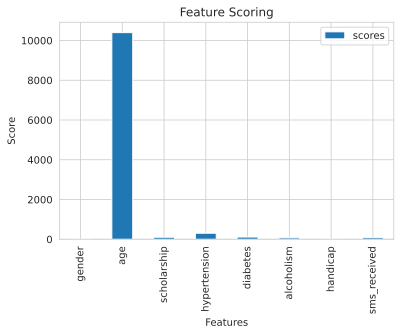

In [53]:

# Visualizing best features using chi squared and their scores each
selectbest_plot = selectbest.iloc[:8,:].plot.bar()
selectbest_plot.set_title('Feature Scoring')
selectbest_plot.set_xticklabels(selectbest['features'])
selectbest_plot.set_xlabel('Features')
selectbest_plot.set_ylabel('Score')

In [0]:
# Top features based on different methods
best_chi_features = ['age']
best_features_importances = ['age', 'scholarship', 'hypertension', 'diabetes', 'alcoholism']
combined_best_features = ['age', 'scholarship', 'hypertension', 'diabetes', 'alcoholism']

In [56]:

# Distribution of classes in the test labels
labels_test.value_counts()

1    69092
0    42491
Name: no_show, dtype: int64

In [57]:
# Proportion of classes that didn't show
print ("Patients who didn't show up: ", labels_test.mean())
print ("Patients who did show up: ", (1 - labels_test.mean()))

# Null Accuracy, ie. accuracy achieved by a dumb model if it only predicted a patient would show up to an appointment
print ("\nNull accuracy is therefore ", max(labels_test.mean(), 1 - labels_test.mean()))

Patients who didn't show up:  0.619198264968678
Patients who did show up:  0.380801735031322

Null accuracy is therefore  0.619198264968678


In [0]:
from sklearn import tree
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler


# Random Forest#

def optimalRFparams():
    '''Runs RandomizedSearchCV through key Random Forest hyperparameters to identify best performing params'''
    clf = RandomForestClassifier(random_state=60)
    params = {
        'n_estimators':np.arange(1000, 1400, 5),
        'max_features':np.arange(1, 20, 1),
        'min_samples_leaf':np.arange(1, 50, 1),
        'min_samples_split':np.arange(1, 50, 1),
        'class_weight':['balanced', None]
    }
    rf_rscv = RandomizedSearchCV(clf, param_distributions=params, cv=cv, n_iter=10, scoring='f1', n_jobs=10, verbose=1)
    rf_rscv.fit(features_train, labels_train)
    
    print (rf_rscv.best_params_)
    print (rf_rscv.best_score_)

def fitRF():
    '''Fitting a RF with the best params found using RandomizedSearchCV'''
    clf = RandomForestClassifier(random_state=60,
                                n_estimators=1350,
                                min_samples_split=31,
                                min_samples_leaf=6,
                                max_features=9,
                                class_weight=None)
    clf.fit(features_train, labels_train)
    pred = clf.predict(features_test)
    
    f_rf = f1_score(pred, labels_test)
    acc_rf = accuracy_score(pred, labels_test)
    
    print ("F-score: ", f_rf)
    print ("Accuracy: ", acc_rf)
    
optimalRFparams()
fitRF()

Fitting 15 folds for each of 10 candidates, totalling 150 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, precision_recall_curve
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

lr = LogisticRegression()

# Fit the model to the data
lr = lr.fit(X_train, y_train)

print ("\n\n ---Logistic Regression Model---")
lr_auc = roc_auc_score(y_test, lr.predict(X_test))

print ("Logistic Regression AUC = %2.2f" % lr_auc)

lr2 = lr.fit(X_train, y_train)
print(classification_report(y_test, lr.predict(X_test)))



 ---Logistic Regression Model---
Logistic Regression AUC = 0.50
              precision    recall  f1-score   support

           0       0.42      0.01      0.02     42574
           1       0.62      0.99      0.76     69009

    accuracy                           0.62    111583
   macro avg       0.52      0.50      0.39    111583
weighted avg       0.54      0.62      0.48    111583



In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

methods_data = {"Original": (X_train, y_train)}

for method in methods_data.keys():
    lr_results = cross_val_score(LogisticRegression(), methods_data[method][0], methods_data[method][1], cv=5, scoring='roc_auc')
    print(f"The best AUC Score for {method} data:")
    print (lr_results.mean())

The best AUC Score for Original data:
0.5593748608560324
